<a href="https://colab.research.google.com/github/pcheruiyot/pcheruiyot/blob/main/PhD_Research_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.0 Introduction**
Australia has one of the most developed residential solar PV market in the world. It however still has huge solar resources that have not been utilized due to various constrains. This research evaluates how these constrains shape the market and influence consumer decision on adoption of residential solar PV. To meet the objectives of the study, a survey was collect views of consumers on residential solar PV installation and how constrains and motivations shape the trend of installation of solar PV in Queensland, Australia. A total of 575 responses where collected from metropolitant and regional Queensland. 

# **Adoption of residential solar PV systems and associated constrains in a mature solar PV market**

## **1.1 Pre_cleaning of raw data**


1.  Unnecesary data columns where removed from the dataset including Qualtrics technical data. 
2. Column names where reformatted for readability
3. column values in education where re-coded


In [1]:
#Loading packages
import pandas as pd
#load data from desktop
from google.colab import files

uploaded = files.upload()

Saving Raw_data.csv to Raw_data.csv


In [2]:
#read dataset
survey_data=pd.read_csv('Raw_data.csv')

## **1.2 Explore data and types** 


In [ ]:
survey_data.dtypes

In [ ]:
#checking for missing values
survey_data.isna().any()

In [ ]:
survey_data['Postcode'].value_counts()

In [ ]:
survey_data['Gender'].value_counts()

In [ ]:
survey_data['Age'].value_counts()

In [ ]:
survey_data['Marital_status'].value_counts()

In [ ]:
survey_data['Education'].value_counts()

In [ ]:
survey_data['Household_size'].value_counts()

In [ ]:
survey_data['Household_income'].value_counts()

In [ ]:
survey_data['Annual_electricity_bill'].value_counts()

## **1.3 Missing values**
The questions on whether a household had solar PV system ('PV_system) had missing values since part of the respondents answer to have installed solar while others have not. For those who had installed solar a few other choices where incorporated to collect data on the configuration of their system and any other complementary electrical equipment they may have acquired for example Electric vehicle, power tools or a battery system (as indicated in the *survey_data.PV_system.value_counts()* below. 

* New sub-columns would be added to separate the items in the PV_system colum and get greater insights into the data. 

* *Intention_to_install_solar* column also had some missing values since 215 of the respondents already had solar in their household  (*survey_data.Installed_solar.value_counts*)

In [ ]:
survey_data['Installed_solar'].value_counts()

In [ ]:
survey_data['Year_of_installation'].value_counts()

## **1.4 Data cleaning**
To continue with EDA, more Python packages are arequired and were loaded in this step. 

In [ ]:
import sklearn
import scipy
!pip install shap
import plotly
import shap
import numpy as np


In [16]:
survey_data.columns

Index(['State', 'Postcode', 'Location', 'Gender', 'Age', 'Marital_status',
       'Education', 'Household_size', 'Household_income',
       'Annual_electricity_bill', 'Installed_solar', 'PV_system',
       'Year_of_installation', 'Intention_to_install_solar', 'Expected_income',
       'Power_bill', 'Installation_cost', 'Government_rebates',
       'Future_energy_cost', 'Political_support', 'Ease_of_connecting_to_grid',
       'Environmental_conservation',
       'Technology_advancement_in_solar_and_storage',
       'Positive_peer_influence', 'Access_to_solar_information',
       'Energy_inpendence', 'Suitability_of_house_location',
       'Property_rights_limitations', 'Minimize_power_outages',
       'House_Aesthetics', 'House_value', 'Other_factors ',
       'Homeownership_status'],
      dtype='object')

In [17]:
#survey data without the state  and other factors columns
subset_survey_data=survey_data.drop(columns=['State', 'Other_factors '])

## **1.5 Splitting the data**
To work on the data we divided the responses into two; those who have solar PV and those who are yet to install 

In [18]:
#filtering survey data of households with solar PV
have_PV=(subset_survey_data['Installed_solar']=='Yes')

### **1.5.1 Subset of data for household with solar**
After removing the state column from the data, a subset of the data containing only entries from households that had installed solar PV was aggregated. The new subset of data was named *subset_have_PV* 

In [19]:
#subset data of households with 
subset_have_PV=subset_survey_data[have_PV]

In [20]:
#filtering survey data of households with solar PV
no_PV=(subset_survey_data['Installed_solar']=='No')

### **1.5.2 Subset of data for household without solar**
Another subset of the data containing responses from households without solar was extracted and named *subset_no_PV* 

In [21]:
#subset data of households without solar
subset_no_PV=subset_survey_data[no_PV]

## Coding string responses
String values in categorical columns where coded to enable further analysis of the data including the use of machine learning models to obtain insights from the data
1.   Location: {Metropolitan=1, Rural/Regional=2)
2.   Gender: {Male=1, Female=2}






In [22]:
from pandas.core.common import pipe
coded_data=(subset_survey_data
 .pipe(lambda subset_survey_data:subset_survey_data.assign(
     Location=subset_survey_data.Location.replace({'Metropolitan':1, 'Regional/Rural':2}), 
     Gender=subset_survey_data.Gender.replace({'Male':1, 'Female':2}),
     Marital_status=subset_survey_data.Marital_status.replace({'Married':1, 'Single':2, 'Divorced':3, 'Separated':4, 'Prefer not to say':0}),
     Education=subset_survey_data.Education.replace({ 'Null':0,"Master's degree or above":1,"Bachelor's degree":2,'High school':3,'Diploma' :4,'Trades':5,
         'Primary':6}),
     Household_income=subset_survey_data.Household_income.replace({'<$25,000':25000, '$25,000-$50,000':37500,'$50,000-$100,000':75000,  '$100,000-$150,000':125000,
       '> $150,000':150000}),
     Annual_electricity_bill=subset_survey_data.Annual_electricity_bill.replace({'< $1000':1000,'$1,000-$1,500':1250, '>$1500':1500}),
     Installed_solar=subset_survey_data.Installed_solar.replace({'No':0,'Yes':1}),
     PV_system=subset_survey_data.PV_system.replace({'Solar panels':1, 'Solar panels,Power tools':1,
       'Solar panels,Battery System':2,
       'Solar panels,Battery System,Power tools':2, 'Battery System':3,
       'Solar panels,Electric Vehicle,Power tools':2,
       'Solar panels,Electric Vehicle':1,
       'Solar panels,Battery System,Electric Vehicle,Power tools':2,
       'Electric Vehicle':1, 'Battery System,Electric Vehicle':2}),
     Intention_to_install_solar=subset_survey_data.Intention_to_install_solar.replace({'Not at all likely':0, 'Somewhat likely':1, 'Most likely':2}),
     Homeownership_status=subset_survey_data.Homeownership_status.replace({'Owner-occupier':1, 'Own a rental/investment property':2,'Renting/leasing a residential property':3
       }),
     Age=subset_survey_data.Age.replace({'18-24':20,'25-34':30, '35-44':40, '45-54':50, '55-64':60,  '65-74':70, '75-84':80,
       '85 and over':85})

 )
 )
)

#subset_survey_data['Location'].value_counts().index

In [23]:
coded_data=(coded_data
            .rename(columns={'Annual_electricity_bill':'electricity_bill',
                             'Technology_advancement_in_solar_and_storage':'technology',
                             'Positive_peer_influence':'peer_influence',
                             'Access_to_solar_information':'information',
                             'Property_rights_limitations':'property_rights',
                             'Minimize_power_outages':'power_outages',
            })
)
                              
                
          

In [24]:
#converting all column names to lowercase for uniformity
coded_data.columns=coded_data.columns.str.lower()

In [25]:
#coded data with all lowercase column names
coded_data

,postcode,location,gender,age,marital_status,education,household_size,household_income,electricity_bill,installed_solar,...,technology,peer_influence,information,energy_inpendence,suitability_of_house_location,property_rights,power_outages,house_aesthetics,house_value,homeownership_status
0,4674,2,2,70,1,5,2,37500,1000,0,...,1,2,3,1,2,6,1,5,1,1
1,4304,1,1,60,3,3,3,37500,1250,1,...,3,2,2,3,4,2,2,2,3,1
2,4000,1,1,50,2,3,5,37500,1250,1,...,3,3,3,3,3,2,3,3,3,1
3,4010,1,1,50,3,2,5,37500,1250,1,...,5,5,3,4,2,3,4,2,4,1
4,4650,2,2,20,2,3,3,37500,1250,0,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,4615,2,1,40,1,3,4,75000,1000,0,...,4,2,3,4,4,2,5,2,5,1
570,4305,1,1,50,1,2,4,125000,1000,1,...,4,3,2,2,4,3,3,3,3,1
571,4161,1,1,30,1,2,4,150000,1500,1,...,3,2,3,2,2,2,3,4,4,1
572,4113,1,1,40,3,3,3,75000,1250,1,...,5,3,4,4,4,3,3,3,4,1


In [26]:
coded_data.dtypes


postcode                           int64
location                           int64
gender                             int64
age                                int64
marital_status                     int64
education                          int64
household_size                     int64
household_income                   int64
electricity_bill                   int64
installed_solar                    int64
pv_system                        float64
year_of_installation             float64
intention_to_install_solar       float64
expected_income                    int64
power_bill                         int64
installation_cost                  int64
government_rebates                 int64
future_energy_cost                 int64
political_support                  int64
ease_of_connecting_to_grid         int64
environmental_conservation         int64
technology                         int64
peer_influence                     int64
information                        int64
energy_inpendenc

In [ ]:
coded_data.columns

# **2.0 Exploratory Data Analysis (EDA)**

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [37]:
(coded_data
 .corr()
 .style
 .background_gradient(cmap='RdBu',vmin=-1,vmax=1)
)

,postcode,location,gender,age,marital_status,education,household_size,household_income,electricity_bill,installed_solar,pv_system,year_of_installation,intention_to_install_solar,expected_income,power_bill,installation_cost,government_rebates,future_energy_cost,political_support,ease_of_connecting_to_grid,environmental_conservation,technology,peer_influence,information,energy_inpendence,suitability_of_house_location,property_rights,power_outages,house_aesthetics,house_value,homeownership_status
postcode,1.000000,0.649701,-0.000291,0.131608,-0.071971,0.096164,0.029921,-0.130240,0.007903,0.041240,-0.051001,-0.004383,0.080694,0.007408,0.012558,-0.017781,0.037837,0.053982,-0.003542,0.032253,0.038050,0.017516,-0.075236,-0.018434,0.034628,0.023731,-0.073916,-0.010476,-0.062364,0.045206,-0.071975
location,0.649701,1.000000,0.051843,0.134367,-0.042704,0.059888,-0.006129,-0.103528,-0.100741,0.052895,-0.048046,0.046908,0.021283,-0.056066,0.002746,0.001514,0.052847,0.048654,-0.026796,0.007219,0.005020,-0.017001,-0.076058,-0.032616,0.035281,-0.031982,-0.110879,-0.049858,-0.086231,0.013230,-0.090317
gender,-0.000291,0.051843,1.000000,-0.220211,0.001141,-0.002213,0.082159,0.035146,-0.008768,-0.055887,-0.059261,0.083508,0.032450,0.045943,0.079199,-0.012309,0.021463,0.081288,0.051450,0.054162,0.125866,-0.040713,0.078269,0.068355,0.022362,0.031594,0.047527,0.025849,-0.013711,0.136501,0.000214
age,0.131608,0.134367,-0.220211,1.000000,-0.039168,0.114421,-0.397536,-0.287744,-0.226620,0.053757,-0.155762,-0.309526,-0.198835,-0.217942,-0.128094,0.001552,-0.034878,-0.021015,-0.145381,-0.062471,-0.108712,-0.137493,-0.375890,-0.123784,-0.072870,-0.020066,-0.174860,-0.112818,-0.146867,-0.184484,-0.232282
marital_status,-0.071971,-0.042704,0.001141,-0.039168,1.000000,-0.018441,-0.247355,-0.283631,-0.040497,-0.155218,0.112431,-0.009744,-0.115273,0.020983,-0.025030,-0.049057,-0.001894,-0.029985,0.014339,-0.050267,0.014714,0.025390,0.007881,-0.005039,-0.019535,-0.055191,0.134445,0.001870,-0.020512,-0.074667,0.312254
education,0.096164,0.059888,-0.002213,0.114421,-0.018441,1.000000,-0.114451,-0.214508,-0.086866,0.004210,-0.208044,-0.186519,-0.228012,-0.018348,0.004323,-0.040180,-0.025517,-0.005505,-0.046163,0.007352,-0.047840,-0.032031,-0.060008,0.006119,-0.028760,-0.065145,-0.013837,-0.030088,-0.074907,0.020192,0.091923
household_size,0.029921,-0.006129,0.082159,-0.397536,-0.247355,-0.114451,1.000000,0.352356,0.303277,0.100400,0.076421,0.177646,0.216309,0.150983,0.094755,0.029668,0.020218,0.070224,0.090890,0.051864,0.070429,0.087537,0.239295,0.069076,0.020920,0.039013,-0.035238,0.065791,0.087245,0.128241,-0.058084
household_income,-0.130240,-0.103528,0.035146,-0.287744,-0.283631,-0.214508,0.352356,1.000000,0.297962,0.097175,0.030726,0.111491,0.278353,0.101085,0.095985,0.029678,0.053259,0.074114,0.005337,0.036352,0.037853,0.035155,0.145579,0.067464,0.041604,0.086037,-0.069564,0.030951,0.077303,0.091807,-0.186979
electricity_bill,0.007903,-0.100741,-0.008768,-0.226620,-0.040497,-0.086866,0.303277,0.297962,1.000000,-0.094874,0.122842,0.027358,0.250845,0.061414,0.069406,0.073523,0.053919,0.039719,-0.019190,0.004176,-0.014776,-0.010767,0.054133,0.033345,0.003146,0.014711,0.013897,0.044920,0.023088,0.071104,-0.040638
installed_solar,0.041240,0.052895,-0.055887,0.053757,-0.155218,0.004210,0.100400,0.097175,-0.094874,1.000000,nan,nan,nan,0.056610,0.062358,-0.106671,-0.051712,0.118316,0.015931,0.069051,0.041220,0.051832,-0.016885,0.065756,0.059246,0.065049,-0.237297,-0.078952,-0.037211,0.093604,-0.407043


Text(0, 0.5, 'Respondents')

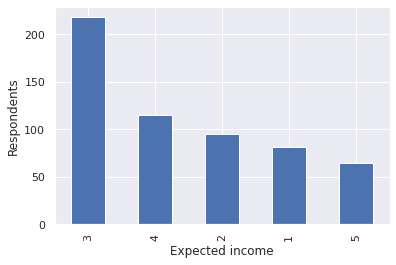

In [113]:
coded_data.expected_income.value_counts() .plot.bar()
plt.xlabel("Expected income")
plt.ylabel("Respondents")


In [114]:
subset_survey_data.columns

Index(['Postcode', 'Location', 'Gender', 'Age', 'Marital_status', 'Education',
       'Household_size', 'Household_income', 'Annual_electricity_bill',
       'Installed_solar', 'PV_system', 'Year_of_installation',
       'Intention_to_install_solar', 'Expected_income', 'Power_bill',
       'Installation_cost', 'Government_rebates', 'Future_energy_cost',
       'Political_support', 'Ease_of_connecting_to_grid',
       'Environmental_conservation',
       'Technology_advancement_in_solar_and_storage',
       'Positive_peer_influence', 'Access_to_solar_information',
       'Energy_inpendence', 'Suitability_of_house_location',
       'Property_rights_limitations', 'Minimize_power_outages',
       'House_Aesthetics', 'House_value', 'Homeownership_status'],
      dtype='object')

In [115]:
feature=['Gender', 'Age', 'Marital_status', 'Education',
       'Household_size', 'Household_income', 'Annual_electricity_bill']

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

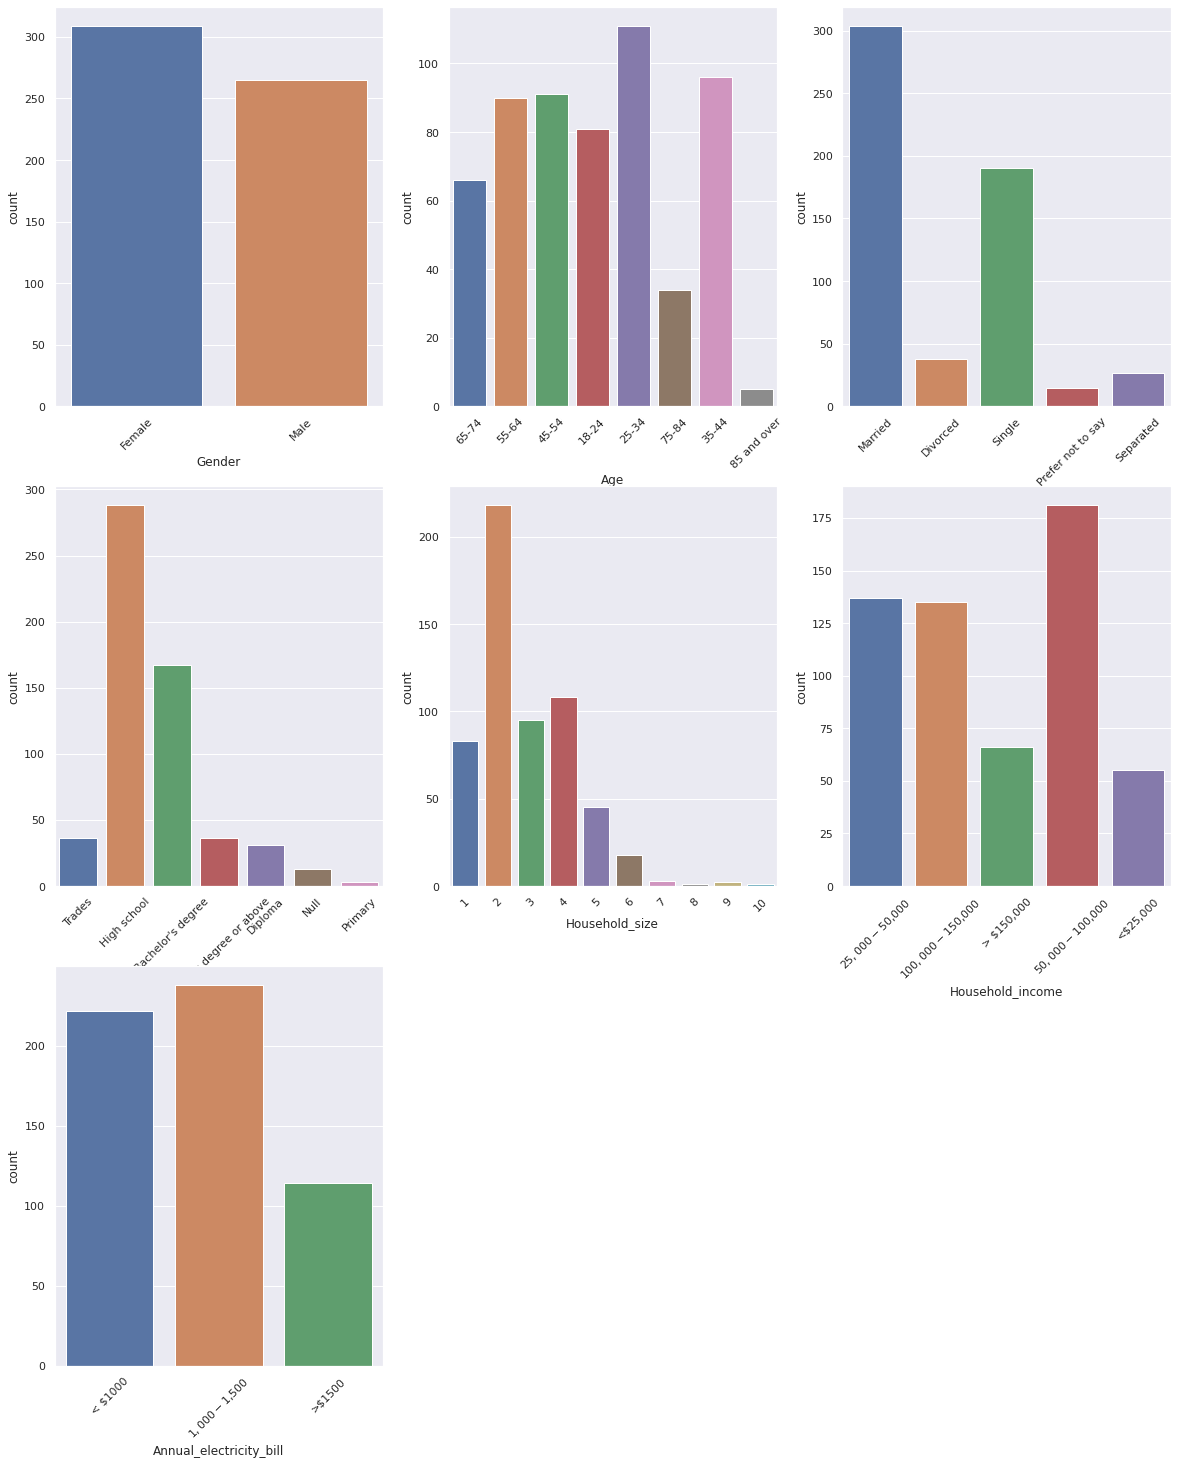

In [126]:
#plotting demographic data
plt.figure(figsize=(20,25))
list(enumerate(feature))
for i in enumerate(feature):
  plt.subplot(3,3,i[0]+1)
  sns.countplot(i[1],data=subset_survey_data)
  plt.xticks(rotation=45)

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


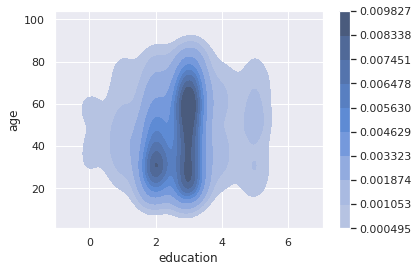

In [192]:
#coded_data['installed_solar'].value_counts()
sns.kdeplot(coded_data.education, coded_data.age, shade=True,cbar=True);


Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


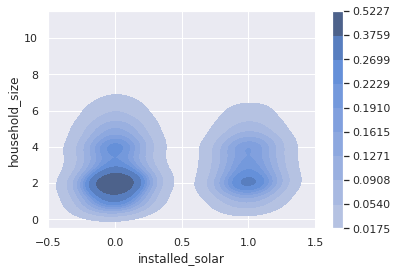

In [193]:
#frequency of installations according to household size
sns.kdeplot(coded_data.installed_solar, coded_data.household_size, shade=True,cbar=True);

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


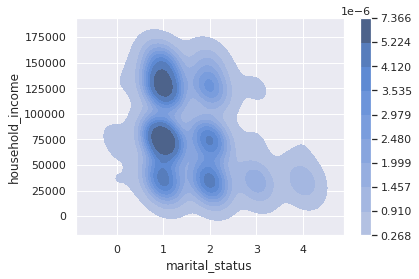

In [194]:
#understanding household income according to marital status
sns.kdeplot(coded_data.marital_status, coded_data.household_income, shade=True,cbar=True);

In [196]:
coded_data.columns

Index(['postcode', 'location', 'gender', 'age', 'marital_status', 'education',
       'household_size', 'household_income', 'electricity_bill',
       'installed_solar', 'pv_system', 'year_of_installation',
       'intention_to_install_solar', 'expected_income', 'power_bill',
       'installation_cost', 'government_rebates', 'future_energy_cost',
       'political_support', 'ease_of_connecting_to_grid',
       'environmental_conservation', 'technology', 'peer_influence',
       'information', 'energy_inpendence', 'suitability_of_house_location',
       'property_rights', 'power_outages', 'house_aesthetics', 'house_value',
       'homeownership_status'],
      dtype='object')

# Machine learning

In [208]:
from pandas.core.frame import DataFrame
from sklearn import decomposition,preprocessing
scaler=preprocessing.StandardScaler()
x=(coded_data
   .drop(columns=['postcode'])
   .pipe(pd.get_dummies)
   .pipe(lambda coded_data:pd.DataFrame(scaler.fit_transform(coded_data),columns=coded_data.columns, index=coded_data.index))
)
x

,location,gender,age,marital_status,education,household_size,household_income,electricity_bill,installed_solar,pv_system,...,technology,peer_influence,information,energy_inpendence,suitability_of_house_location,property_rights,power_outages,house_aesthetics,house_value,homeownership_status
0,1.394127,0.926070,1.307297,-0.686068,2.273424,-0.581312,-1.050456,-1.094729,-0.773877,NaN,...,-1.935255,-0.735822,-0.311658,-2.236274,-1.322873,2.143285,-1.790174,1.942083,-2.119935,-0.797105
1,-0.717295,-1.079832,0.758567,1.686238,0.287206,0.116749,-1.050456,0.253714,1.292195,-0.401742,...,-0.285906,-0.735822,-1.238559,-0.457173,0.451260,-0.742921,-0.983612,-0.470808,-0.414479,-0.797105
2,-0.717295,-1.079832,0.209837,0.500085,0.287206,1.512872,-1.050456,0.253714,1.292195,2.066101,...,-0.285906,0.093965,-0.311658,-0.457173,-0.435806,-0.742921,-0.177050,0.333489,-0.414479,-0.797105
3,-0.717295,-1.079832,0.209837,1.686238,-0.705903,1.512872,-1.050456,0.253714,1.292195,2.066101,...,1.363442,1.753540,-0.311658,0.432377,-1.322873,-0.021370,0.629512,-0.470808,0.438249,-0.797105
4,1.394127,0.926070,-1.436354,0.500085,0.287206,0.116749,-1.050456,0.253714,-0.773877,NaN,...,-0.285906,0.093965,-0.311658,-0.457173,-0.435806,-0.021370,-0.177050,0.333489,-0.414479,1.402597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,1.394127,-1.079832,-0.338894,-0.686068,0.287206,0.814810,-0.158061,-1.094729,-0.773877,NaN,...,0.538768,-0.735822,-0.311658,0.432377,0.451260,-0.742921,1.436073,-0.470808,1.290977,-0.797105
570,-0.717295,-1.079832,0.209837,-0.686068,-0.705903,0.814810,1.031800,-1.094729,1.292195,-0.401742,...,0.538768,0.093965,-1.238559,-1.346724,0.451260,-0.021370,-0.177050,0.333489,-0.414479,-0.797105
571,-0.717295,-1.079832,-0.887624,-0.686068,-0.705903,0.814810,1.626730,1.602158,1.292195,-0.401742,...,-0.285906,-0.735822,-0.311658,-1.346724,-1.322873,-0.742921,-0.177050,1.137786,0.438249,-0.797105
572,-0.717295,-1.079832,-0.338894,1.686238,0.287206,0.116749,-0.158061,0.253714,1.292195,-0.401742,...,1.363442,0.093965,0.615242,0.432377,0.451260,-0.021370,-0.177050,0.333489,0.438249,-0.797105


In [214]:
x.std

<bound method NDFrame._add_numeric_operations.<locals>.std of      location    gender       age  marital_status  education  household_size  \
0    1.394127  0.926070  1.307297       -0.686068   2.273424       -0.581312   
1   -0.717295 -1.079832  0.758567        1.686238   0.287206        0.116749   
2   -0.717295 -1.079832  0.209837        0.500085   0.287206        1.512872   
3   -0.717295 -1.079832  0.209837        1.686238  -0.705903        1.512872   
4    1.394127  0.926070 -1.436354        0.500085   0.287206        0.116749   
..        ...       ...       ...             ...        ...             ...   
569  1.394127 -1.079832 -0.338894       -0.686068   0.287206        0.814810   
570 -0.717295 -1.079832  0.209837       -0.686068  -0.705903        0.814810   
571 -0.717295 -1.079832 -0.887624       -0.686068  -0.705903        0.814810   
572 -0.717295 -1.079832 -0.338894        1.686238   0.287206        0.116749   
573 -0.717295 -1.079832 -0.338894       -0.686068   0.2872